## <font style="color:lightblue">Header</font>

### <font style="color:lightblue">Imports</font>

In [1]:
#%load_ext autoreload
#%autoreload 2

import math
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import itertools
import random
import torchvision

import shiftpatch_module as sg




### <font style="color:lightblue">Redefine</font>

In [2]:
sg.plt.rcParams['figure.dpi']=223





### <font style="color:lightblue">Configs</font>

In [3]:
sg.set_seed(7)

sg.TCfg = sg.TCfgClass(
     exec = 1
    ,nofEpochs = None
    ,latentDim = 64
    ,batchSize = 2**9
    ,batchSplit = 1
    ,loaderWorkers = 16
    ,labelSmoothFac = 0.1 # For Fake labels (or set to 0.0 for no smoothing).
    ,learningRateD = 5e-4
    ,learningRateG = 5e-4
)

sg.DCfg = sg.DCfgClass()


### <font style="color:lightblue">Raw Read</font>

In [4]:
sg.samplingMask = sg.SamplingMask()
sg.samplingVari = sg.SamplingVariations()
sg.trainSet = sg.createTrainSet()
sg.testSet = sg.createTestSet()
sg.testLoader = sg.createDataLoader(sg.createSubSet(sg.testSet),
                                    num_workers=sg.TCfg.loaderWorkers)
sg.refImages, sg.refNoises = sg.createReferences(0)

### <font style="color:lightblue">Show</font>

(1, 403, 553, 295)


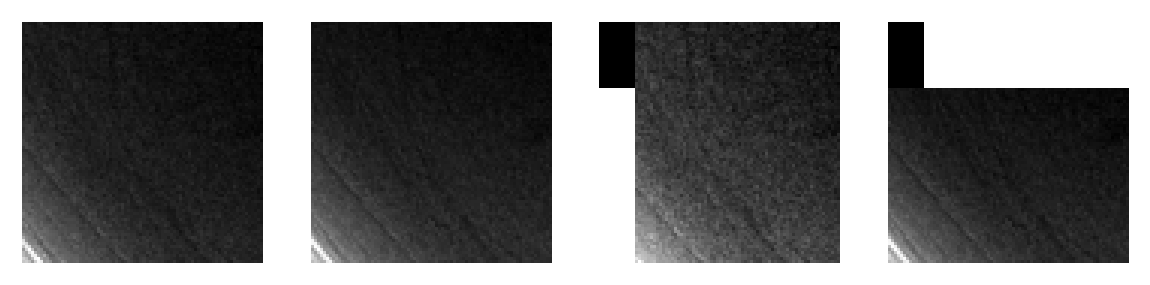

In [5]:

sg.showMe(sg.testSet)

## <font style="color:lightblue">Models</font>

### <font style="color:lightblue">Generator</font>

In [6]:
blurTransform = torchvision.transforms.GaussianBlur( 1 + 2 * sg.TCfg.maximumArtificialShift ,
                                                     1 * sg.TCfg.maximumArtificialShift )



save_interim = False
class Generator(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator, self).__init__(-1)
        self.amplitude = 4

        self.noise2latent = self.createLatent()

        self.encoders =  nn.ModuleList([
            self.encblock( (4+abs(self.latentChannels)) /self.baseChannels,
                               1, 3, norm=False,),
            self.encblock( 1,  1, 3, norm=True, dopadding=True),
            self.encblock( 1,  2, 3, norm=True, stride=2),
            self.encblock( 2,  2, 3, norm=True, dopadding=True),
            self.encblock( 2,  4, 3, norm=True, stride=2),
            self.encblock( 4,  4, 3, norm=True, dopadding=True),
            self.encblock( 4,  8, 3, norm=True, stride=2),
            self.encblock( 8,  8, 3, norm=True, dopadding=True),
            self.encblock( 8, 16, 3, norm=True, stride=2),
            self.encblock(16, 16, 3, norm=True, dopadding=True),
            ])

        self.fcLink = self.createFClink()

        self.decoders = nn.ModuleList([
            self.decblock(32, 16, 3, norm=True, dopadding=True),
            self.decblock(32,  8, 4, norm=True, stride=2),
            self.decblock(16,  8, 3, norm=True, dopadding=True),
            self.decblock(16,  4, 4, norm=True, stride=2),
            self.decblock( 8,  4, 3, norm=True, dopadding=True),
            self.decblock( 8,  2, 4, norm=True, stride=2),
            self.decblock( 4,  2, 3, norm=True, dopadding=True),
            self.decblock( 4,  1, 4, norm=True, stride=2),
            self.decblock( 2,  1, 3, norm=True, dopadding=True),
            self.decblock( 2,  1, 3, norm=False),
            ])

        self.lastTouch = self.createLastTouch()

        #sg.load_model(self, model_path="model_0_gen.pt" )


    def preProc(self, images):
        with torch.no_grad() :
            orgDims = images.dim()
            if orgDims == 3 :
                images = images.view(1, *images.shape)
            masks = images[:,2:,...]
            presentInBoth = masks[:,0,...] * masks[:,1,...]
            sumOrg = torch.where(presentInBoth > 0, 0.5 + images[:,0,...], 0).sum(dim=(-1,-2))
            sumSft = torch.where(presentInBoth > 0, 0.5 + images[:,1,...], 0).sum(dim=(-1,-2))
            procImages = images[:,0:4,...].clone().detach()
            #blurImages = blurTransform(procImages)
            #blurImages[:,0:2,...] /= torch.where ( blurImages[:,2:4,...] > 0, blurImages[:,2:4,...], 1 )
            coef = torch.sqrt( torch.where( sumOrg * sumSft != 0, sumOrg / sumSft, 1 ) ).view(-1,1,1)
            procImages[:,0,...] = masks[:,0,...] * \
                ( procImages[:,0,...] / coef - 0.5 * (1 - 1/coef) )
            procImages[:,1,...] = masks[:,1,...] * \
                ( procImages[:,1,...] * coef - 0.5 * (1 - coef) )
        return procImages, (coef, orgDims)


    def postProc(self, images, cfg):
        coef, orgDims = cfg
        pimages0 = images[:,0,...] * coef + 0.5 * (coef - 1)
        pimages1 = images[:,1,...] / coef + 0.5 * (1/coef - 1)
        pimages = torch.stack((pimages0, pimages1), dim=1)
        if orgDims == 3 :
            pimages = pimages.view(1, *images.shape)
        return pimages



sg.generator = Generator().to(sg.TCfg.device)
sg.optimizer_G = sg.createOptimizer(sg.generator, sg.TCfg.learningRateG)
model_summary = summary(sg.generator, input_data=[ [sg.refImages[[0],0:4,...], sg.refNoises[[0],...]] ] ).__str__()
#print(model_summary)

#_ = sg.testMe(sg.refImages)

### <font style="color:lightblue">Discriminator</font>

In [7]:

class Discriminator(sg.DiscriminatorTemplate):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.param = nn.Parameter(torch.zeros(1))
    def forward(self, images):
        return torch.zeros((images.shape[0],1), device=sg.TCfg.device)

sg.discriminator = Discriminator()
sg.discriminator = sg.discriminator.to(sg.TCfg.device)
model_summary = summary(sg.discriminator, input_data=sg.refImages[0,...] ).__str__()
#print(model_summary)
#sg.writer.add_graph(sg.discriminator, refImages)

sg.optimizer_D = sg.createOptimizer(sg.discriminator, sg.TCfg.learningRateD)



## Loss

In [8]:
def my_loss_Rec(p_true, p_pred, masks):
    return sg.loss_SSIM(p_true, p_pred, masks) #+ 10 * sg.loss_MSE(p_true, p_pred, masks)
sg.loss_Rec = my_loss_Rec

#sg.normRec, sg.normMSE, sg.normL1L = sg.summarizeSet(
#                                            sg.createDataLoader(
#                                                sg.createSubSet(sg.trainSet),
#                                                num_workers=sg.TCfg.loaderWorkers))[0:3]
#sg.normTestRec, sg.normTestMSE, sg.normTestL1L = sg.summarizeSet(sg.testLoader)[0:3]
sg.normRec, sg.normMSE, sg.normL1L = 0.2265182205452719, 0.005452611889724605, 0.04321732757587487
sg.normTestRec, sg.normTestMSE, sg.normTestL1L = 0.07887759477150198, 0.0009257564545033881, 0.016588556742668754
#print((sg.normRec, sg.normMSE, sg.normL1L))
#print((sg.normTestRec, sg.normTestMSE, sg.normTestL1L))

## <font style="color:lightblue">Restore checkpoint</font>

In [10]:

sg.scheduler_G = torch.optim.lr_scheduler.StepLR(sg.optimizer_G, 1, gamma=1-0.001)
sg.scheduler_D = torch.optim.lr_scheduler.StepLR(sg.optimizer_D, 1, gamma=1-0.001)
#sg.scheduler_D = torch.optim.lr_scheduler.StepLR(sg.optimizer_D, 1, gamma=0.999)
savedCheckPoint = f"checkPoint_{sg.TCfg.exec}"
sg.epoch, sg.imer, sg.minRecTest, sg.minRecTrain, sg.minTestEpoch, sg.startFrom, sg.resAcc = \
    sg.restoreCheckpoint(savedCheckPoint+".pth")
sg.startFrom = 0
#sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.startFrom = 0, 0, 0, 1, 0
sg.writer = sg.createWriter(sg.TCfg.logDir, True)
#sg.writer.add_graph(sg.generator, ((sg.refImages, sg.refNoises),) )
#sg.writer.add_graph(sg.discriminator, refImages)
#_ = sg.restoreCheckpoint(savedCheckPoint+".pth")
print(f"Initial LR : {sg.scheduler_D.get_last_lr()[0]} {sg.scheduler_G.get_last_lr()[0]}")

Initial LR : 0.00018588222393577024 0.00018588222393577024


## Test me

Losses: Rec 0.04836531555802541, MSE 0.000889919037168051, L1L 0.01932570793175623. Pixels: 8667.0.


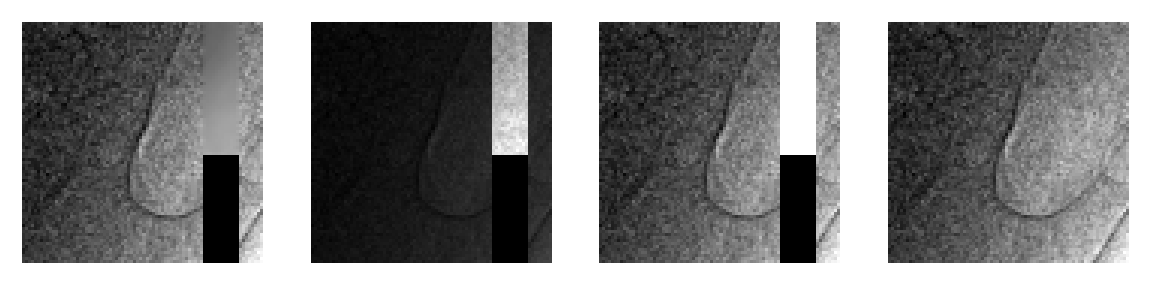

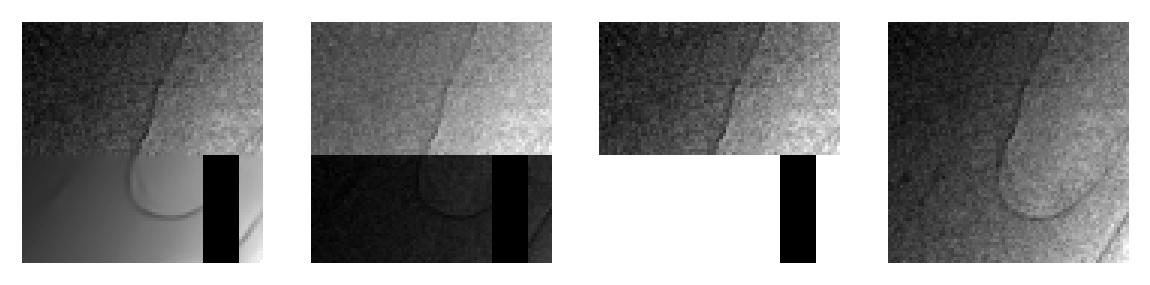

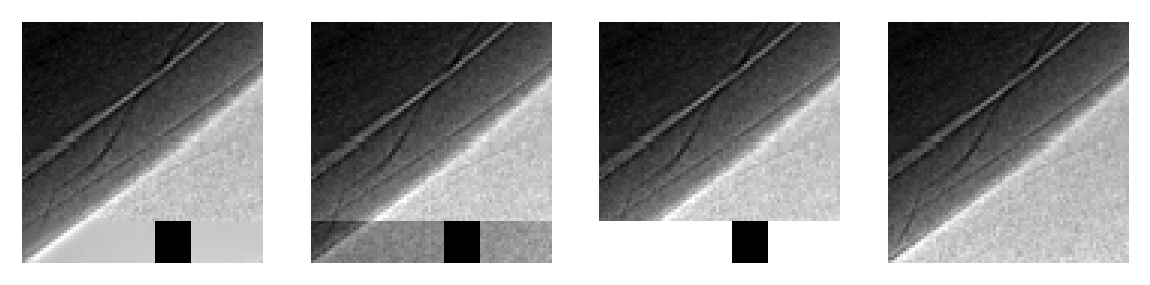

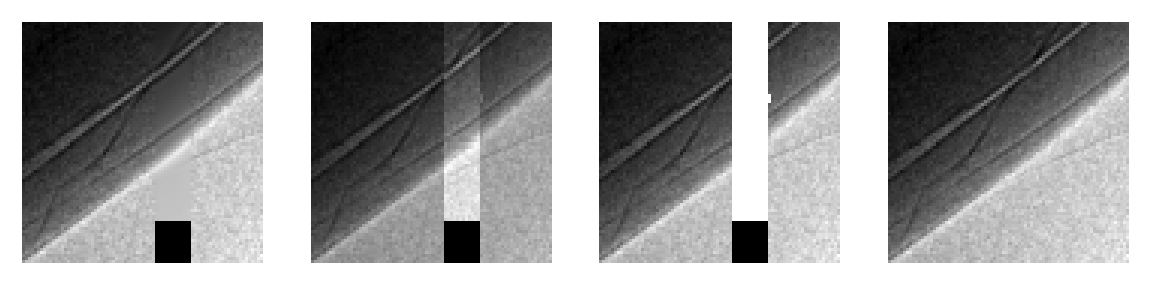

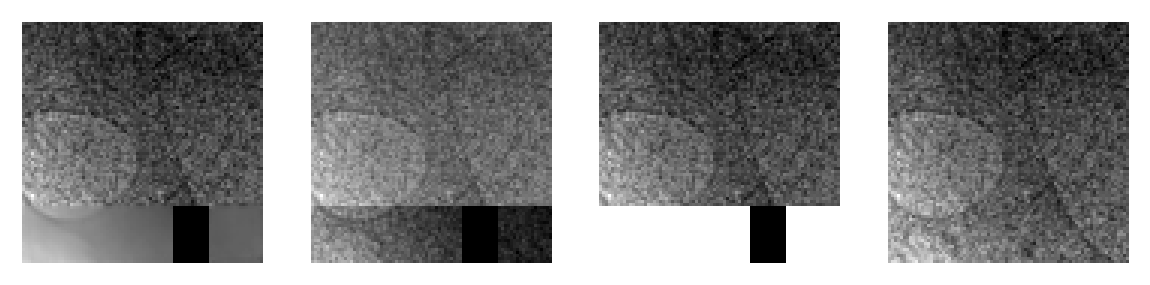

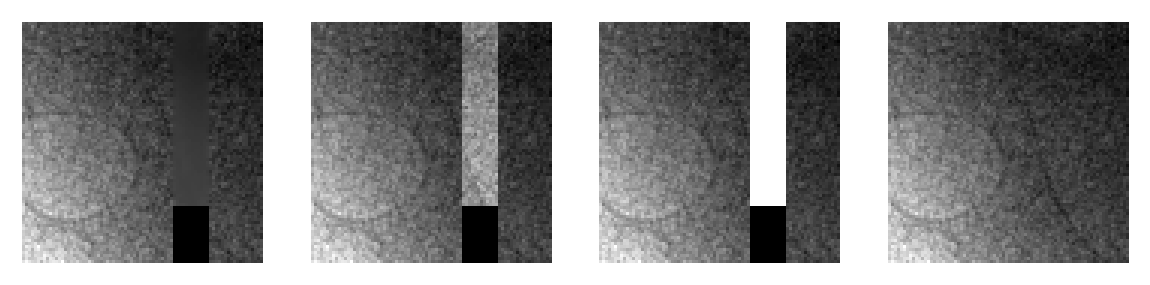

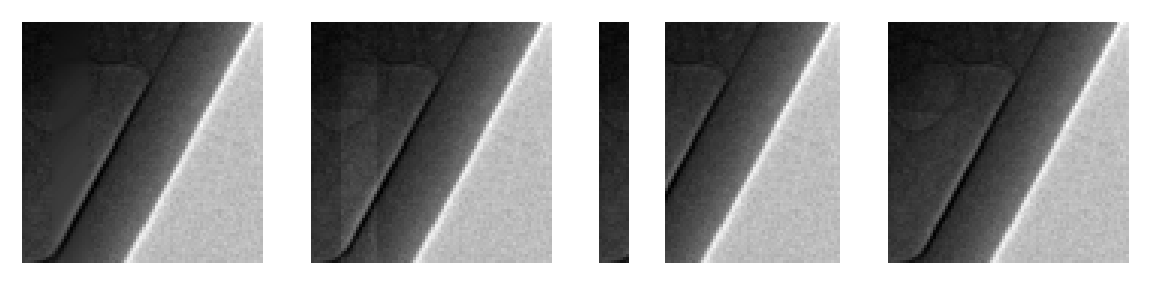

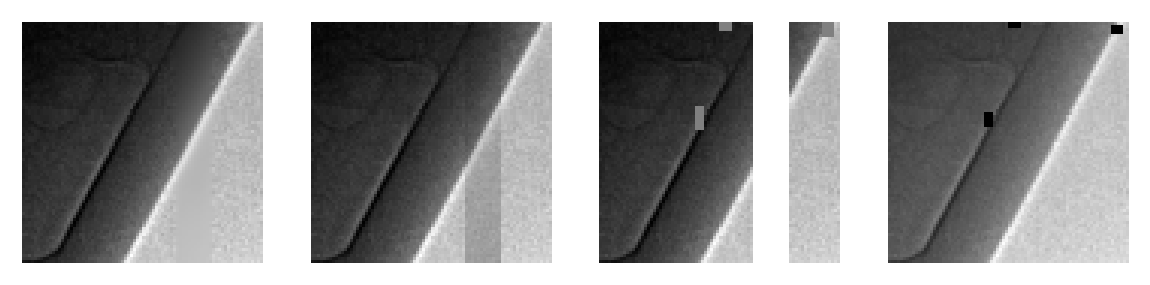

In [11]:

_ = sg.testMe(sg.refImages)


## <font style="color:lightblue">Execute</font>

LR : 0.00016717818725655984 0.334
Epoch:  30 ( 28). L1L: 0.682  MSE: 0.490  Rec: 0.412  (Train: 0.413/0.413, Test: 0.230/0.230).
Image [3, 11848, 128, 915]. L1L: 0.553  MSE: 0.180  Rec: 0.368 
Reference images. L1L: 0.443  MSE: 0.160  Rec: 0.214 


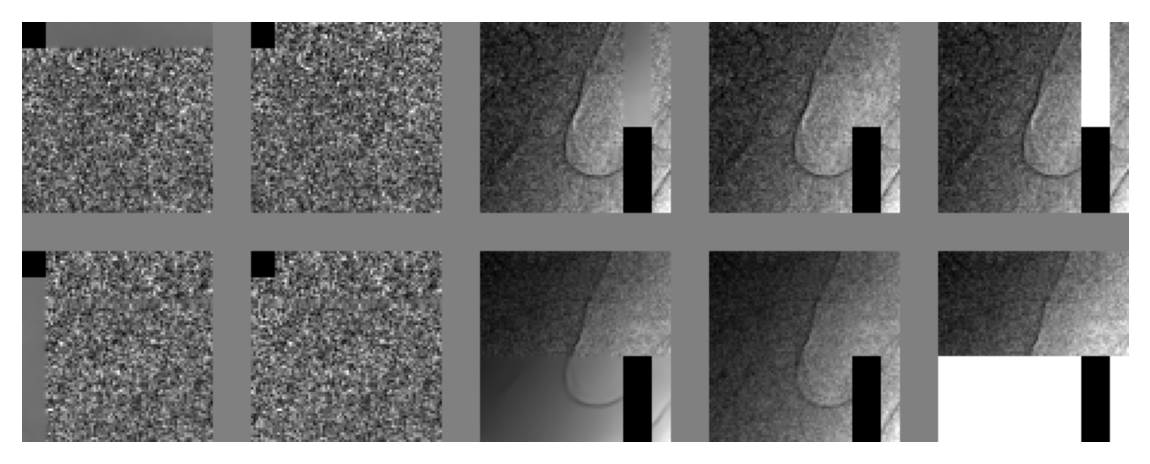

100%|██████████| 3079/3079 [1:49:28<00:00,  2.13s/it]


Losses: Rec 0.04823344243746033, MSE 0.00087950437886225, L1L 0.019221693941008276. Pixels: 8667.0.


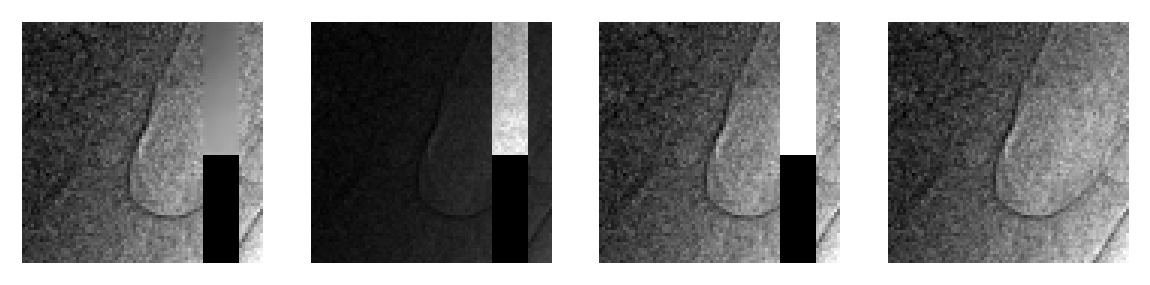

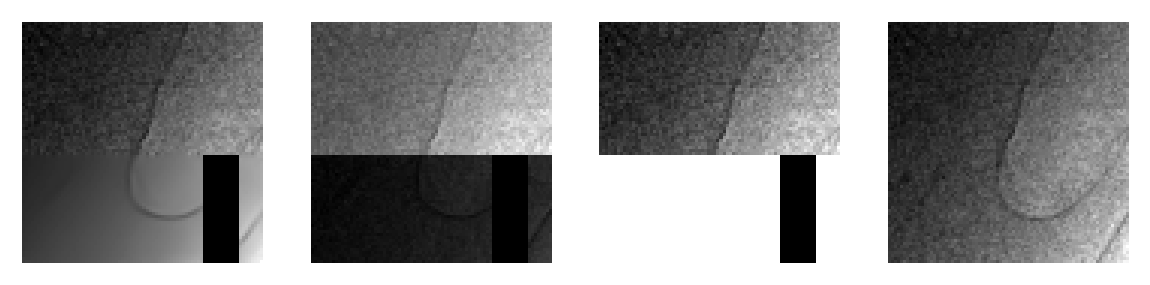

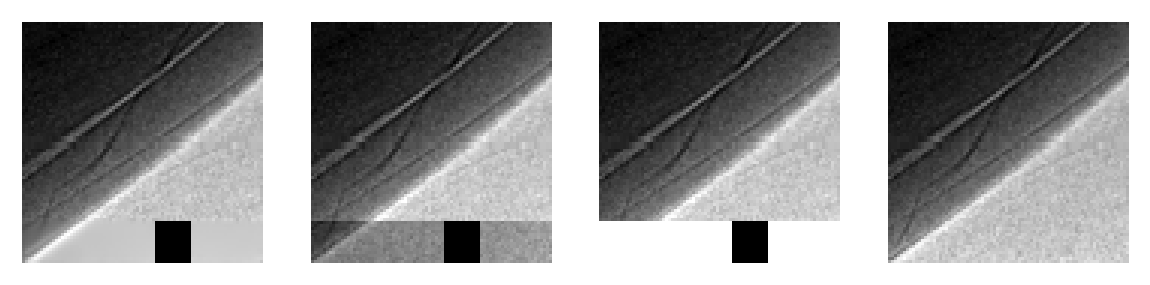

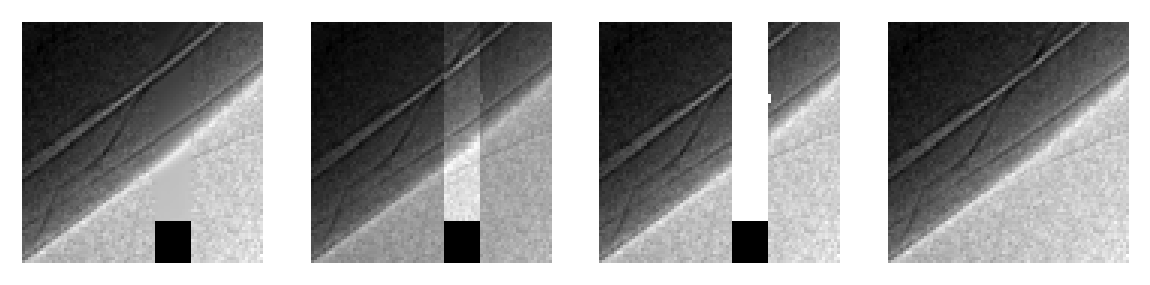

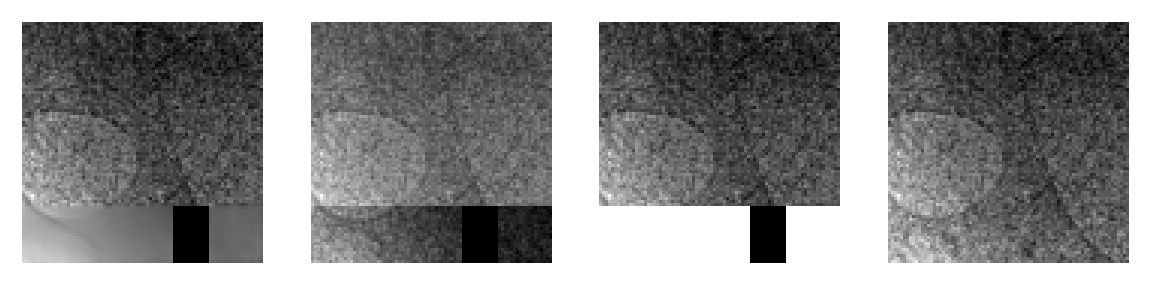

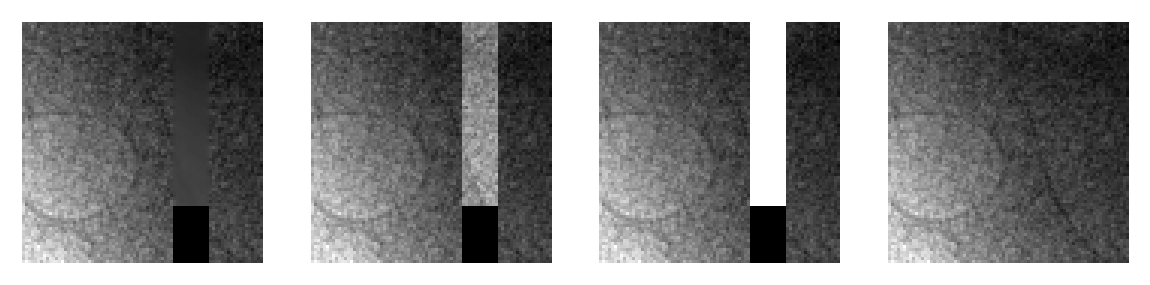

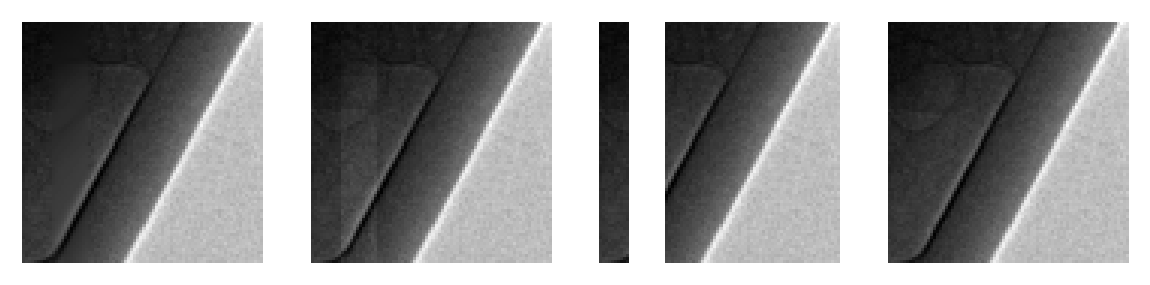

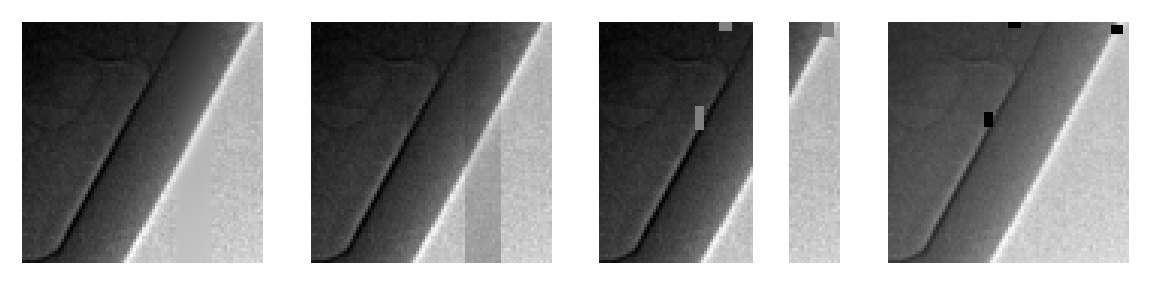

100%|██████████| 318/318 [04:03<00:00,  1.31it/s]


Summary. Rec: 1.818e-02, MSE: 5.034e-04, L1L: 1.003e-02, Dis: 0.000e+00, Gen: 0.000e+00.


  0%|          | 0/3079 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [12]:
#torch.autograd.set_detect_anomaly(True)
sg.noAdv = True

#def my_afterEachEpoch(epoch) :
#    if sg.minGEpoch < 600 :
#        return
#    if not sg.dataLoader is None :
#        del sg.dataLoader
#        sg.freeGPUmem()
#    if sg.TCfg.batchSize < 131072 :
#    sg.TCfg.batchSize += round( 0.01 * sg.TCfg.batchSize )
#    sg.dataLoader = sg.createTrainLoader(trainSet, num_workers=24)
#    print("Batch size: ",sg.TCfg.batchSize)
#sg.afterEachEpoch = my_afterEachEpoch

sg.scheduler_G = torch.optim.lr_scheduler.StepLR(sg.optimizer_G, 1, gamma=1-0.001)
sg.scheduler_D = torch.optim.lr_scheduler.StepLR(sg.optimizer_D, 1, gamma=1-0.001)
def my_beforeReport(_) :
    lastLR = sg.scheduler_G.get_last_lr()[0]
    print(f"LR : {lastLR} {lastLR/sg.TCfg.learningRateG:.3f}")
    if lastLR  <  0.01 * sg.TCfg.learningRateG :
        return
    if sg.scheduler_G is not None :
        sg.scheduler_G.step()
    if sg.scheduler_D is not None :
        sg.scheduler_D.step()
    return
sg.beforeReport = my_beforeReport

sg.lossAdvCoef = 1.0
sg.lossDifCoef = 1.0

#def my_beforeReport() :
#    #print(sg.normRec, sg.normMSE, sg.normL1L)
#    #print(sg.normTestRec, sg.normTestMSE, sg.normTestL1L)
#    return
#sg.beforeReport = my_beforeReport

try :
    sg.train(savedCheckPoint)
except :
    #del sg.dataLoader
    #del sg.testLoader
    sg.freeGPUmem()
    1/10 # to release Jupyuter memory in the next step
    sg.epoch -= 1
    raise



## <font style="color:lightblue">Post</font>

In [ ]:
print (sg.generator.amplitude.item(), 2 * torch.sigmoid(sg.generator.amplitude).item() )
sg.initialTest()


In [ ]:
sg.testMe(trainSet, 5)

### <font style="color:lightblue">Save results</font>

In [ ]:
sg.saveModels()